# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')
from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


**Данные о клиентах банка:**

* `age` (возраст);
* `job` (сфера занятости);
* `marital` (семейное положение);
* `education` (уровень образования);
* `default` (имеется ли просроченный кредит);
* `housing` (имеется ли кредит на жильё);
* `loan` (имеется ли кредит на личные нужды);
* `balance` (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* `contact` (тип контакта с клиентом);
* `month` (месяц, в котором был последний контакт);
* `day` (день, в который был последний контакт);
* `duration` (продолжительность контакта в секундах).

Прочие признаки:

* `campaign` (количество контактов с этим клиентом в течение текущей кампании);
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* `previous` (количество контактов до текущей кампании)
* `poutcome` (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Видим что 25 пропущенных значений у нас есть в столбце balance 

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique() 

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [5]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В столбце job (сфера занятости) есть неизвестные значения, обозначенные как 'unknown'

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_to_float(x):
    #print(x)
    if x is np.NaN:
        return np.NaN
    elif str(x)[0] == '0':
        return 0
    else:
        return float(x.replace('$', '').replace(' ', '').replace(',00', ''))


df['balance'] = df['balance'].apply(balance_to_float)

In [7]:
#Вычислите среднее значение по преобразованному в корректный вид признаку balance. 
#Ответ округлите до трёх знаков после точки-разделителя.
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)

In [9]:
#Вычислите среднее значение по преобразованному в корректный вид признаку balance. 
#Ответ округлите до трёх знаков после точки-разделителя.
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [11]:
round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(),3)

1598.883

### Задание 6

In [12]:
# удалите все выбросы для признака balance

def drop_iqr(df, col, left=1.5, right=1.5, log_scale=False, add_one=False):
    """Drop outliers using the interquartile range method (Tukey's method)

    Args:
        df (DataFrame): pandas DataFrame
        col (str): column name
        log_scale (bool, optional): converting to the natural log scale. 
                                    Defaults to False.
        add_one (bool, optional): add 1 to all values, 
                                  (works for the log scale only,
                                  usefull if there are zeros in data). 
                                  Defaults to False.
        left (float, optional): lower IQR bound. Defaults to 1.5.
        right (float, optional): upper IQR bound. Defaults to 1.5.

    Returns:
        tuple: a tuple containing the cleaned dataframe, the calculated 
               lower and upper bounds, and the dataframe with outliers
    """
    
    if log_scale and add_one:
        x = np.log(df[col]+1)
    elif log_scale and not add_one:
        x = np.log(df[col])
    else:
        x = df[col]
    
    percentile_1, percentile_3 = np.percentile(x, 25), np.percentile(x, 75),
    print= (percentile_1, percentile_3)
    iqr = percentile_3 - percentile_1
    lower_bound = percentile_1 - (iqr*left)
    upper_bound = percentile_3 + (iqr*right)
    outliers = df[(x<lower_bound) | (x>upper_bound)]
    clean_df = df[(x>=lower_bound) & (x<=upper_bound)]
    
    return clean_df, lower_bound, upper_bound, outliers


df, lower_bound, upper_bound, _ = drop_iqr(df, 'balance')
print(lower_bound, upper_bound, df.shape[0])

-2241.0 4063.0 10105


Сколько объектов осталось после удаления всех выбросов?

In [13]:
df['balance'].count()

10105

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

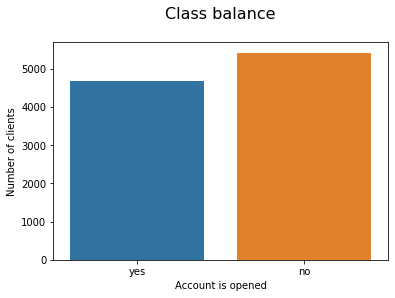

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts())
display(df['deposit'].value_counts(normalize=True))

ax = sns.countplot(df['deposit'])
ax.set(xlabel='Account is opened', ylabel='Number of clients')
ax.set_title('Class balance\n',fontsize=16);


### Задание 2

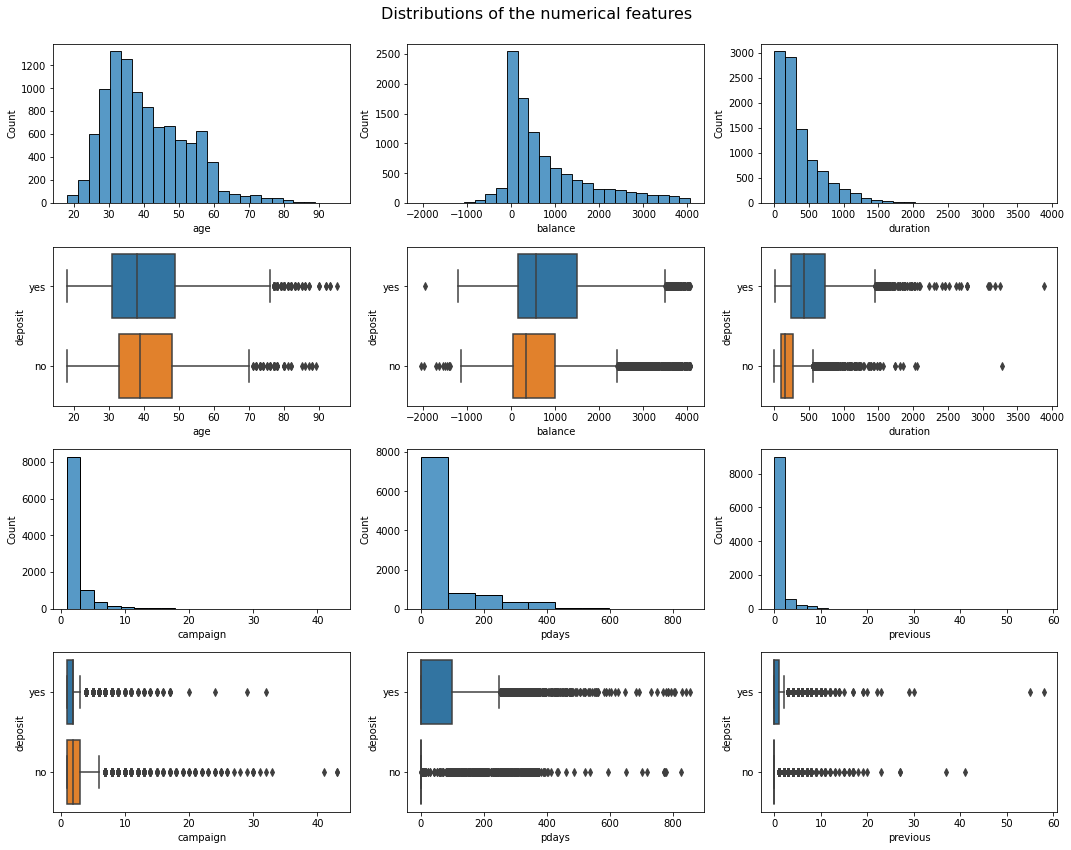

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(df['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(df['balance'], bins=25, ax=ax[0,1])   # Баланс
sns.histplot(df['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(df['campaign'], bins=20, ax=ax[2,0])  # Количество контактов
sns.histplot(df['pdays'], bins=10, ax=ax[2,1])     # Количество дней после предыдущей кампании
sns.histplot(df['previous'], bins=25, ax=ax[2,2])  # Количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

#### *Общий вид распределений, выбросы*
    
* *Возраст (age).* Пик распределения возраста приходится на 30-35 лет с достаточно большим количеством клиентов допенсионного возраста, количество клиентов старше 60 лет резко падает. Распределение с правой асимметрией в сторону старшего возраста.
* *Баланс (balance).* Есть небольшое количество отрацительных балансов. В остальном распределение логнормальное с преобладанием небольших балансов. Возможно, следует дополнительно убрать выбросы отрицательного баланса, расположенные левее границы распределения (менее $\sim-1100$).
* *Продолжительность контакта (duration).* Средняя продолжительность контакта около 5 мин. Распределение логнормальное. Возможно наличие выбросов - контакт более 30 мин.
* *Количество контактов (campaign).* Логнормальное. Выбросы - число контактов более 15.
* *Количество дней с момента предыдущей кампании (pdays).* Логнормальное. Выбросы - более 500 дней.
* *Количество предыдущих контактов (previous).* Логнормальное. Выбросы аналогичны признаку campaign - более 15.

Для более точного определения границ распределений и удаления выбросов желательно предварительно преобразовать часть признаков в логарифмическую шкалу и применить критерий Тьюки или $3\sigma$.

#### *Влияние на целевой признак*

Визуально значимые отличия в распределениях по отношению к целевому признаку - открытию депозита (deposit) - наблюдаются у нескольких признаков (см. диаграммы размаха). На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Наоборот, большее количество контактов говорит о меньших шансах, т.е. попытки контактировать с клиентом более нескольких раз не имеют особого смысла, результат либо достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признаков pdays и previous говорит о том, что старый друг лучше новых двух - большинство клиентов, не открывших депозит, относятся к новым (pdays=-1, previous=0). Распределение по возрасту для клиентов, не открывших депозит, имеет меньшую дисперсию по сравнению с открывшими, но медианные значения почти не отличаются.

Каков максимальный возраст клиента банка? 
Ответ: 95

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте **в количестве секунд**.  Ответ: 2

In [16]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задание 3

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


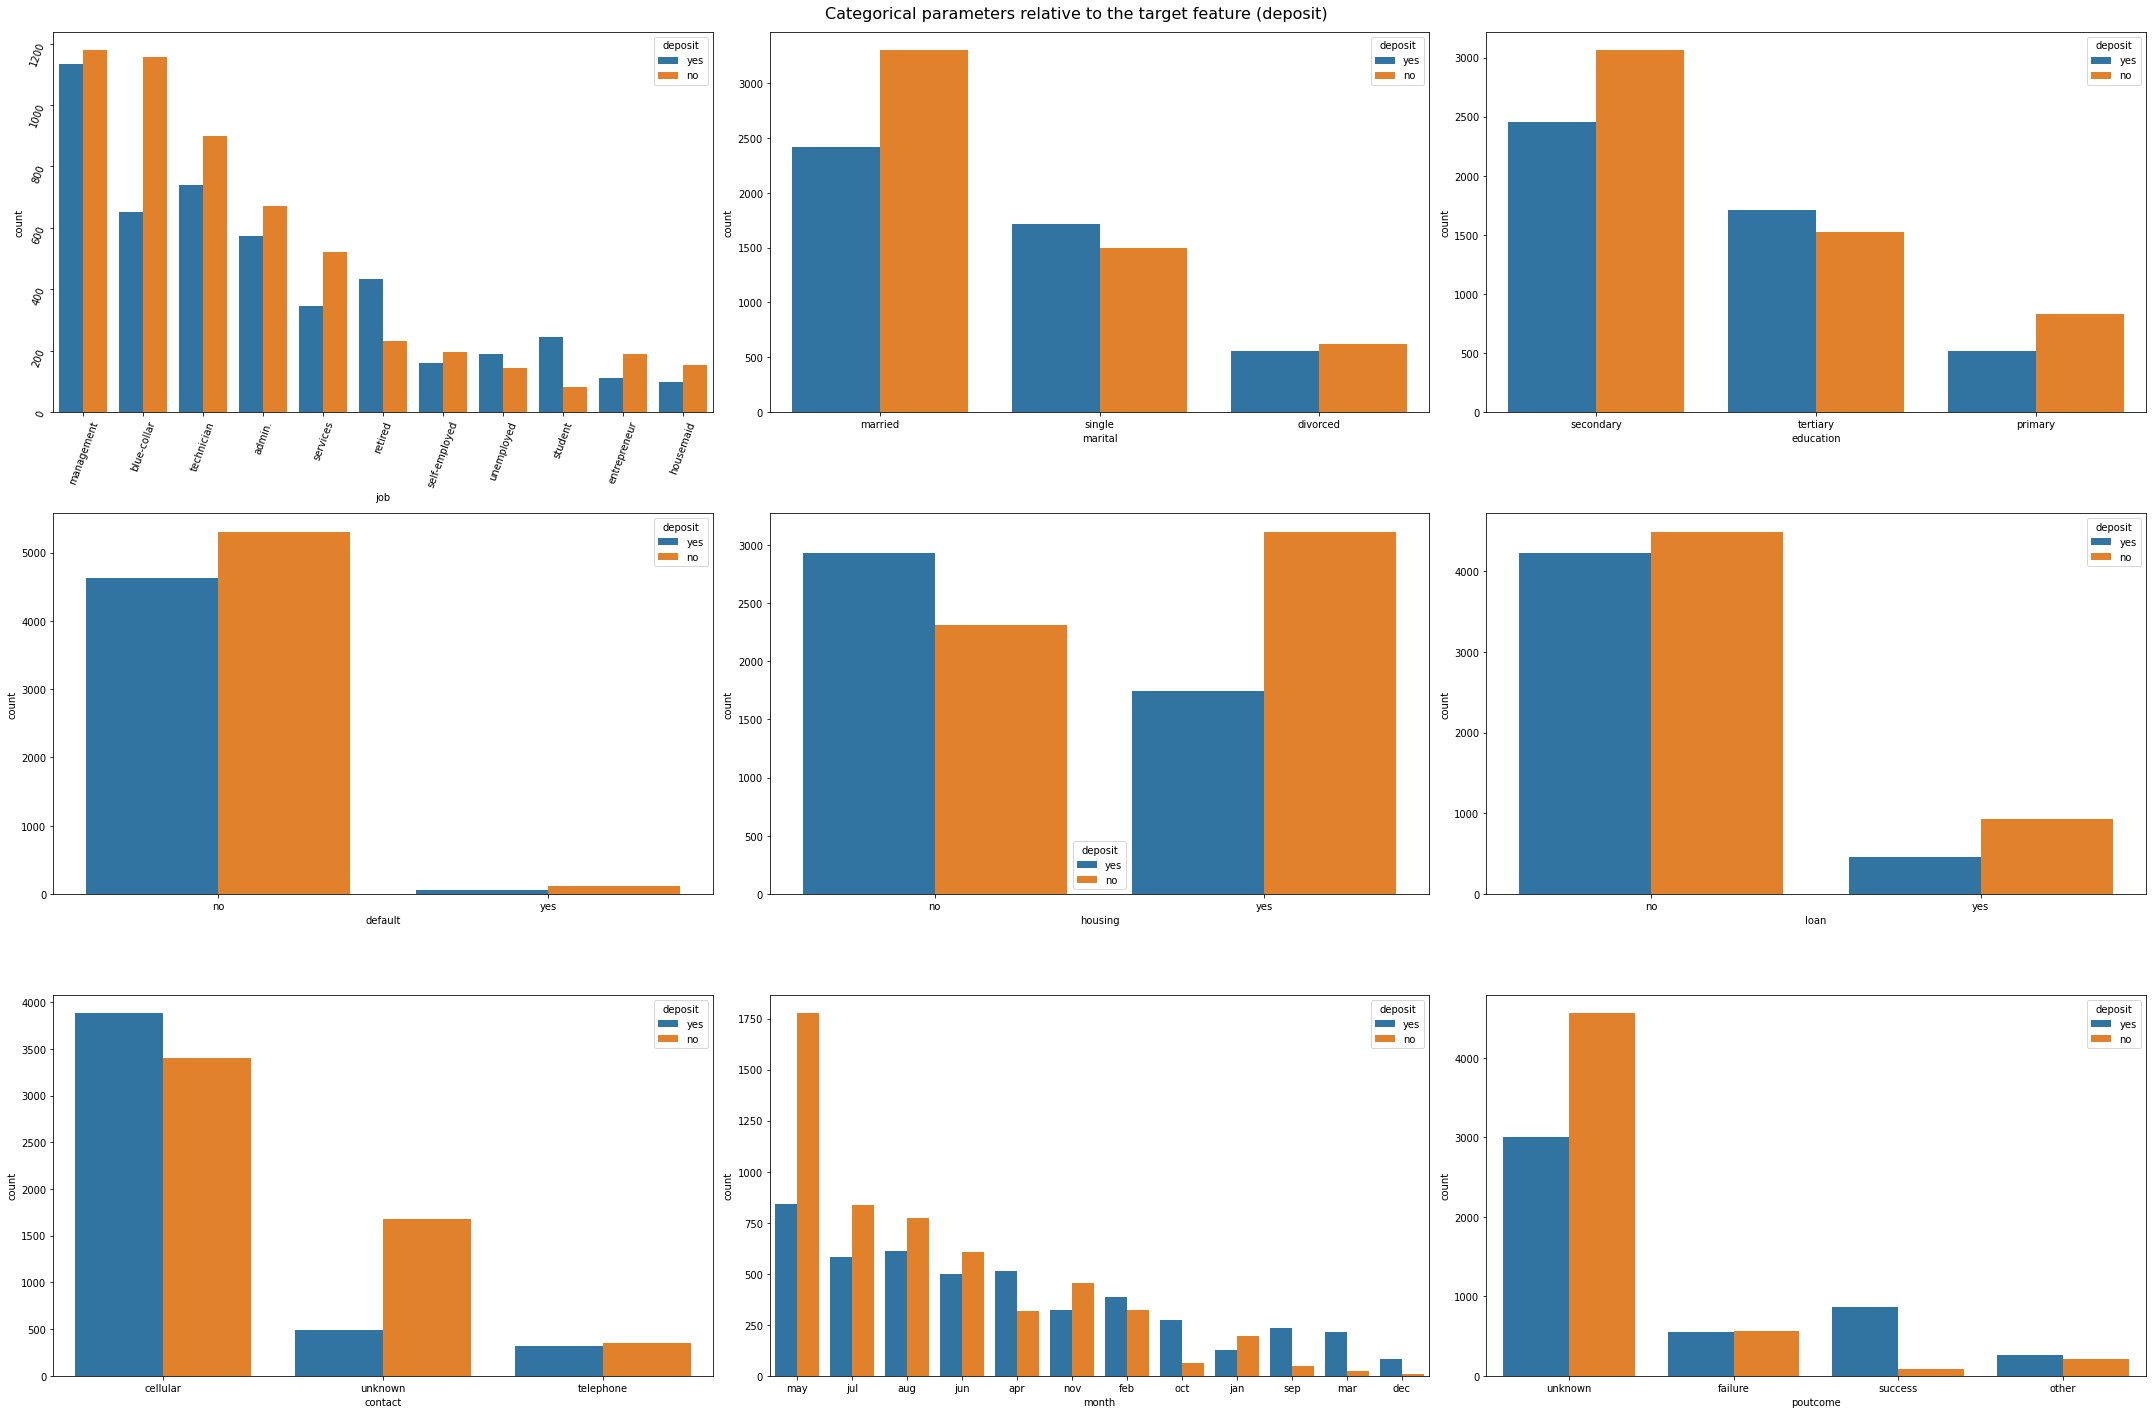

In [17]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты

display(df.describe(include='object'))

fig, ax = plt.subplots(3,3, figsize=(30,20))

# Сфера занятости
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[0,1])

# Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[0,2])

# Наличие просроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[1,0])

# Наличие ипотеки
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[1,1])

# Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[1,2])

# Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit', 
    order=df['contact'].value_counts().index, ax=ax[2,0])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[2,1])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[2,2])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()


На рисунке видим соотношения различных категорий клиентов в разрезе достижения целевого признака - открытия депозита (deposit). Можно сказать, что наиболее склонны к открытию депозита следующие категории клиентов:

* пенсионеры и студенты (при небольшом относительном количестве и тех и других);
* клиенты, по которым был достигнут успех в предыдущей маркетинговой кампании - подавляющее большинство дают положительный результат и в текущей кампании;
* неженатые/незамужние клиенты, а также клиенты, не имеющие ипотеки (и те, и другие - в меньшей степени, однако в этих категориях число клиентов, открывших депозит, превышает число отрицательных результатов, что довольно нетипично для выборки в целом);
* клиенты, с которыми связывались по мобильному телефону - та же картина.

Наиболее неудачные результаты по привлечению к открытию депозита:

* "синие воротнички";
* клиенты с потребительскими кредитами

По какой-то причине наблюдаются значительные различия в успешности маркетинговой кампании по месяцам: исключительно успешные результаты в марте, апреле, сентябре, октябре и декабре, но существенный провал в мае. Данное обстоятельство требует дополнительного изучения в контексте построения модели машинного обучения - результаты могут быть связаны с конкретными "локальными" обстоятельствами маркетинговой кампании и не отражать общей тенденции (зависимости от времени года). Включение такой локальной зависимости в модель приведет к успешному предсказанию текущей ситуации, в том числе на тестовой выборке, однако нет гарантии, что новые данные будут соответствовать модели.

Сколько было месяцев, в которых проводилась маркетинговая кампания?

In [18]:
display(df['month'].value_counts().count())
display(df['month'].describe(include = 'object'))

12

count     10105
unique       12
top         may
freq       2617
Name: month, dtype: object

Сколько сфер занятости представлено среди клиентов банка?

In [19]:
display(df['job'].value_counts().count())

11

### Задание 4

In [20]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 5

In [21]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# процент отказов/согласия по месяцам:
(df.groupby('month')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values('no', ascending=False)  

# Максимум отказов в процентном соотношении - май

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [22]:
for x in df['month'].value_counts().index:
    result = (df['month'] == x).count()
    y = round((df['month'] == x).value_counts()[1] / result *100,2)
    print(x, y)

may 25.9
jul 14.03
aug 13.71
jun 10.93
apr 8.21
nov 7.72
feb 7.02
oct 3.32
jan 3.16
sep 2.75
mar 2.35
dec 0.92


In [23]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задание 6

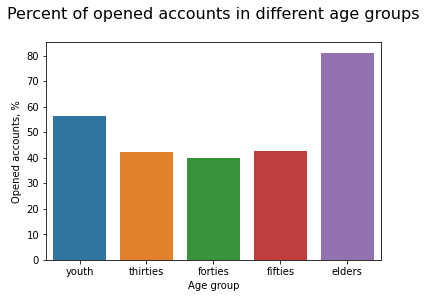

In [24]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Первый способ решения с помощью метода cut()
cut_labels_4 = ['youth', 'thirties', 'forties', 'fifties', 'elders']
cut_bins = [0, 30, 40, 50, 60, 200]

df['age_group'] = pd.cut(df['age'],
                       bins=cut_bins,
                       labels=cut_labels_4)

piv_tab = (df.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
ax = sns.barplot(
    data=piv_tab, x='age_group', y='yes', 
    order=['youth', 'thirties', 'forties', 'fifties', 'elders'])
ax.set(ylabel='Opened accounts, %', xlabel='Age group')
ax.set_title('Percent of opened accounts in different age groups\n', 
             fontsize=16);

### Задание 7

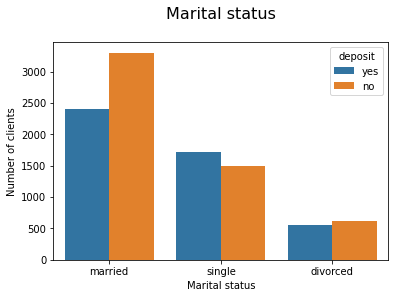

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ax = sns.countplot(data=df, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16);

Наиболее многочисленная группа - семейные, наиболее малочисленная - разведенные. Неженатые/незамужние более склонны к открытию депозита, чем семейные.

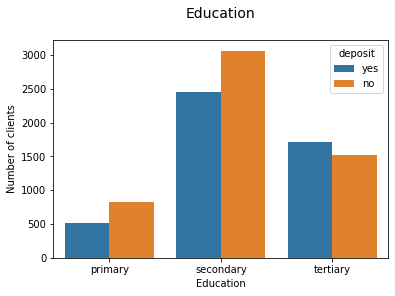

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ax = sns.countplot(data=df, x='education', hue='deposit',
              order=['primary', 'secondary', 'tertiary'])
ax.set(xlabel='Education', ylabel='Number of clients')
ax.set_title('Education\n', fontsize=14);

У большинства клиентов среднее образование. Более склонны к открытию депозита клиенты с высшим образованием.

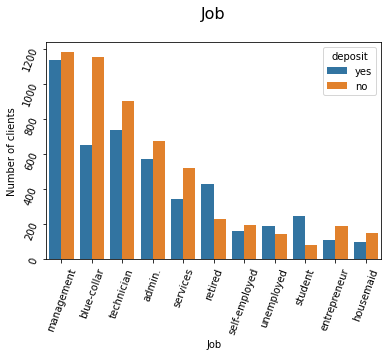

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
ax= sns.countplot(data=df, x='job', hue='deposit', 
              order=df['job'].value_counts().index)
ax.tick_params(labelrotation=70)
ax.set(xlabel='Job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16);

Выделяется малый процент открытия депозитов у "синих воротничков" и большой - у пенсионеров и студентов. Важно отметить, что при этом "синие воротнички" составляют вторую по численности категорию клиентов (стоить подумать о способах привлечения этой категории).

In [28]:
# В какой сфере занято наибольшее число клиентов банка?
df['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

### Задание 8

'кто открыл депозит'

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


'не открыл депозит'

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


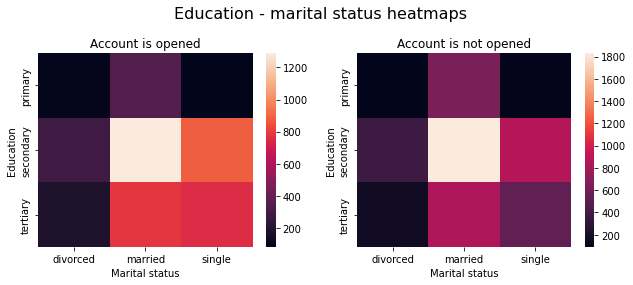

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

success = df[df['deposit']=='yes']
fail = df[df['deposit']=='no']
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()
## or:
#success_pivot = pd.pivot_table(success,     
#    index='education', columns='marital', values='age', aggfunc='count')  
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display('кто открыл депозит',success_pivot, 'не открыл депозит',fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()


В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [30]:
# преобразуйте уровни образования

# Порядковое кодирование
# 0 - primary, 1 - secondary, 2 - tertiary
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])


In [31]:
#Найдите сумму получившихся значений для признака education.
df['education'].sum()

11995

Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [32]:
# Работает не правильно
# df['age_group'] = pd.cut(df.age, [30,40,50,60,9999])
# label_enc = preprocessing.LabelEncoder()
# df['age_group'] = label_enc.fit_transform(df['age_group'])

In [33]:
# Порядковое кодирование возрастных групп

def age_group(x):
    if x < 30:
        return 0  # youth
    elif 30 <= x < 40:
        return 1  # thirties
    elif 40 <= x < 50:
        return 2  # forties
    elif 50 <= x < 60:
        return 3  # fifties 
    else:
        return 4  # elders
    

df['age_group'] = df['age'].apply(age_group)

In [34]:
# Перекодируем признак для соответствия ответам на обучающей платформе

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], 
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])
label_enc = preprocessing.LabelEncoder()
df['age_group'] = label_enc.fit_transform(df['age_group'])

### Задание 2

In [35]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Один из способов
# df.replace({'yes': 1, 'no': 0}, inplace=True)

In [36]:
lb = preprocessing.LabelBinarizer()
df['deposit'] = lb.fit_transform(df['deposit'])

Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.

In [37]:
round(df['deposit'].std(),3)

0.499

Преобразуем в бинарные переменные в представление из нулей и единиц то же самое для других бинарных переменных, которых у нас три:

* 'default';
* 'housing';
* 'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [38]:
lb = preprocessing.LabelBinarizer()
df['default'] = lb.fit_transform(df['default'])
df['housing'] = lb.fit_transform(df['housing'])
df['loan'] = lb.fit_transform(df['loan'])

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [39]:
round((df['default'].mean() + df['housing'].mean() + df['loan'].mean()),3)

0.635

### Задание 3

In [40]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, dummies], axis=1)

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [41]:
print('Количество строк: {}'.format(df.shape[1]))  

Количество строк: 51


In [42]:
# Удаляем преобразованные признаки типа object

obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)

### Задание 4

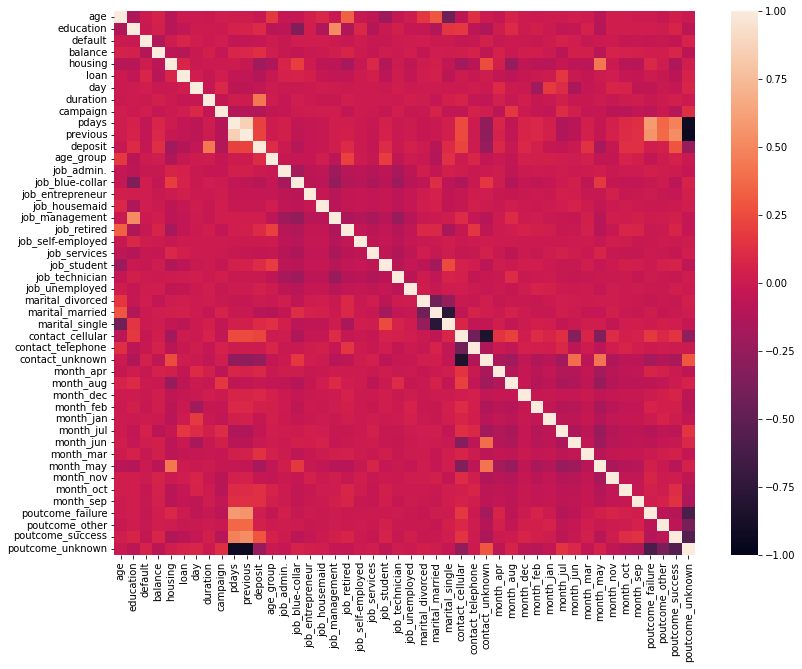

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Корреляционная матрица 
# Используем корреляцию Кендала - распределение признака может быть 
# не нормальным, связь признаков не обязательно является монотонной функцией
corr_matrix = df.corr(method='kendall')

# Тепловая карта
fig = plt.figure(figsize=(13,10))
sns.heatmap(corr_matrix,  vmin=-1, vmax=1);


Расставьте признаки 'poutcome_success', 'duration', 'contact_cellular', в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.

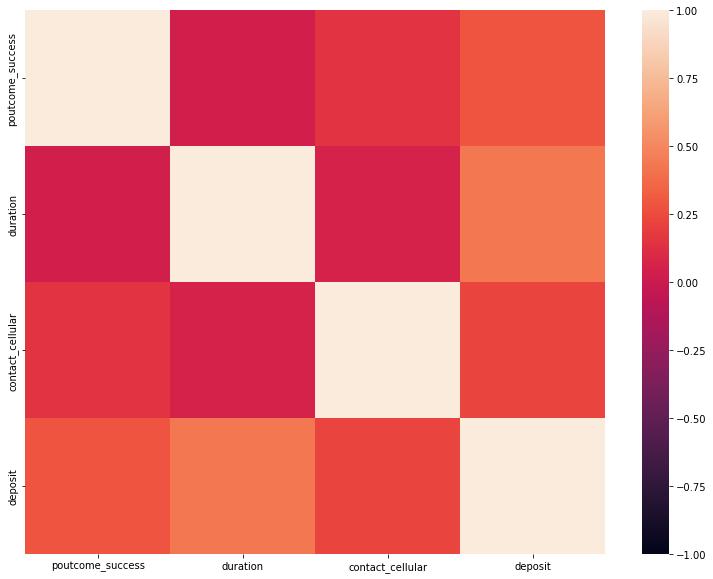

In [44]:
corr_matrix_3 = df[['poutcome_success', 'duration', 'contact_cellular', 'deposit']].corr(method='kendall')

# Тепловая карта
fig = plt.figure(figsize=(13,10))
sns.heatmap(corr_matrix_3,  vmin=-1, vmax=1);

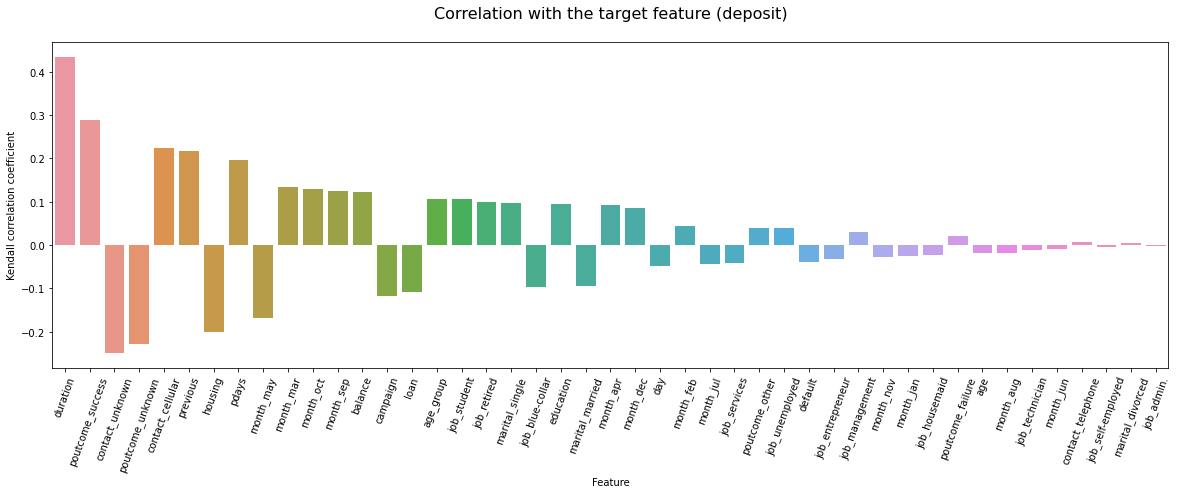

In [45]:
# Корреляция с целевым признаком

fig = plt.figure(figsize=(20,6))
plot_df = corr_matrix.drop('deposit')  # Убираем корреляцию "сам с собой"
feature_order = abs(plot_df['deposit']).sort_values(ascending=False).index
ax = sns.barplot(
    data=plot_df.reset_index(), x='index', y='deposit',
    order = feature_order)
plt.xticks(rotation=70)
ax.set(xlabel='Feature', ylabel='Kendall correlation coefficient')
ax.set_title('Correlation with the target feature (deposit)\n', fontsize=16);

In [46]:
# Вычисляем мультиколлинеарные признаки, порог 0.9 
# (порог в соответствии с требованиями задания).
# Использую заготовленную функцию определения мультиколлинеарных признаков

def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


get_correlated(corr_matrix, thres=0.9)

previous -- poutcome_unknown   -0.938271
pdays -- poutcome_unknown      -0.925560
dtype: float64

### Задание 5

In [47]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
# Стратифицированное разбиение
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [48]:
# рассчитайте необходимые показатели
#Каким получился размер тестовой выборки?
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 6770
Размер тестовой выборки: 3335


In [49]:
# Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.
round(y_test.mean(),2)

0.46

### Задание 6

In [50]:
# # с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Данный способ убирает названия колонок
# selector = SelectKBest(score_func=f_classif, k=15)
# selector.fit(X_train, y_train)
# selected_cols = selector.get_feature_names_out()
# print(f'Selected features:\n {selected_cols}')
# X_train = selector.transform(X_train)
# X_test =selector.transform(X_test)

In [51]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')

X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Selected features:
 ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 7

In [52]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
# X_train = X_train.loc[:,(selected_cols)]
# X_test = X_test.loc[:,(selected_cols)]

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [54]:
round(X_train[:, 0].mean(),2)

0.47

In [55]:
#Преобразуем массив в DataFrame
X_train = pd.DataFrame(X_train, columns = selected_cols)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [56]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

#Делаем предсказание класса
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
#Выводим отчёт о метриках
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=2)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=2)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 2

In [57]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)
#Выводим отчёт о метриках
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=2)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=2)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



*Задание*: "Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой)."

В соответствии с условиями задания подбор параметра идет на тестовой выборке. В реальности ручной подбор гиперпараметра следует делать кросс-валидацией (например с помощью validation_curve() из sklearn) или на отдельной валидационной выборке.

Максимальная точность на тесте: 0.81
Оптимальная глубина дерева: 6


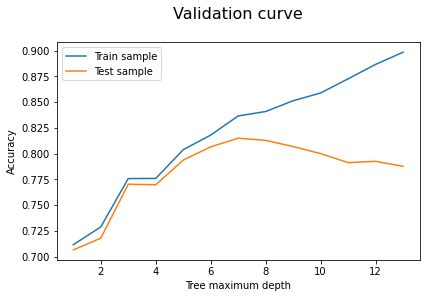

In [58]:
# Перебираем значения max_deph 
# Считаем accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
for max_depth in range(1,14):
    dtree = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    dtree.fit(X_train, y_train)
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Рисунок
max_depth = list(range(1,14))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Tree maximum depth', ylabel='Accuracy')
ax.set_title('Validation curve\n', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.2f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

### Задание 3

In [59]:
# подберите оптимальные параметры с помощью gridsearch
# Сетка параметров
param_grid = [
    {'max_depth': [3, 5, 7],
     'min_samples_split': [2, 5, 7, 10]
    }
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_rf = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    param_grid=param_grid, 
    scoring = 'f1',
)  
grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)

print("f1 на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

f1 на тренировочной выборке: 0.83
f1 на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [60]:
# обучите на ваших данных случайный лес
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = 5, #минимальное число объектов в листе
    max_depth=10, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf.predict(X_test)
#Выводим отчёт о метриках
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.839     0.808     0.824      1790
           1      0.787     0.821     0.804      1545

    accuracy                          0.814      3335
   macro avg      0.813     0.815     0.814      3335
weighted avg      0.815     0.814     0.814      3335



### Задание 2

In [61]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)

y_test_pred = gboost.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.850     0.822     0.836      1790
           1      0.801     0.832     0.816      1545

    accuracy                          0.826      3335
   macro avg      0.825     0.827     0.826      3335
weighted avg      0.827     0.826     0.827      3335



### Задание3

In [62]:
# объедините уже известные вам алгоритмы с помощью стекинга 
dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
logregr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train, y_train)

y_test_pred = stacked.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.836     0.835     0.835      1790
           1      0.809     0.810     0.810      1545

    accuracy                          0.823      3335
   macro avg      0.822     0.822     0.822      3335
weighted avg      0.823     0.823     0.823      3335



### Задание 4

In [63]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
 
estimator = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

In [64]:
selector.ranking_

array([ 1,  4,  1,  8,  3, 11,  5, 12,  2,  6,  9,  7, 10,  1, 13])

In [65]:
X_train.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задание 5

In [66]:
random_state = 42
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

# Поиск оптимальных гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)
study_rf = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами  
optuna_rf = ensemble.RandomForestClassifier(
    **study_rf.best_params, class_weight='balanced', n_jobs=-1,
    random_state=42
)
optuna_rf.fit(X_train, y_train)
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

NameError: name 'obj_func' is not defined

In [ ]:
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))